# Identifying active irrigated cropping

* **Products used:** 
[ls8_st](https://explorer.digitalearth.africa/ls8_st), 
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr), 
[crop_mask](https://explorer.digitalearth.africa/crop_mask), 
[ERA5 Climate Data](https://registry.opendata.aws/ecmwf-era5/)


## Background

One of the well-known measures of plant health is canopy temperature. In conditions with limited water, it can be assumed transpiration decreases and plant temperature subsequently increases. This can often happen during periods of moisture stress in dryland (rainfed) cropping systems but can be overcome by water application in irrigated cropping systems. 

In the field, canopy temperatures can be measured by handheld radiometers. This sort of data is used at a small scale to examine crop health and yield under a variety of conditions. At larger scales, an alternative method is to use surface temperature detected by satellites such as Landsat 8 to calculate similar metrics. In this notebook, we will use $\Delta T$ to differentiate between dryland and irrigated cropland, where $\Delta T$ is:

\begin{equation}
\Delta T = T_c - T_a
\end{equation}

where

* $T_c$ is crop canopy temperature
* $T_a$ is air temperature

Lower $\Delta T$ is associated with higher rates of transpiration as evaporative cooling from transpiration cools the canopy, while higher $\Delta T$ indicates lower rates of transpiration and thereby moisture stress.

In this case, we will use measurements of air temperature modelled by ERA5 to approximate $T_a$ and the Landsat surface temperature product to approximate $T_c$.

## Description
In this notebook, we calculate $\Delta T$  and visualise over irrigated areas.

The following steps are taken:

1. Load Landsat 8 Surface Temperature data
2. Load ERA5 "Air temperature at 2 metres" data for the same area of interest
3. Calculate $\Delta T$
4. Visualise $\Delta T$
5. Use a simple cluster analysis to differentiate between irrigated and dryland cropping.
6. Map irrigated cropping within the area of interest.

***

## Load packages

In [1]:
%matplotlib inline

# Force GeoPandas to use Shapely instead of PyGEOS
# In a future release, GeoPandas will switch to using Shapely by default.
import os
os.environ['USE_PYGEOS'] = '0'


import datacube
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.algo import xr_reproject
from matplotlib.colors import ListedColormap

from deafrica_tools.load_era5 import load_era5
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import rgb, display_map
from datacube.utils.geometry import Geometry
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from deafrica_tools.areaofinterest import define_area

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Landsat_ST")

### Analysis parameters

This analysis focuses on cropland in Sudan. The western portion of the area of interest appear irrigated, as it is serviced by canals on close inspection, and vegetation is greener than surrounding landscape features. The eastern portion of the area is mostly dryland cropping.

#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button ![upload_files_icon.png](upload_files_icon.png) in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.


In [3]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=13.8489, lon=33.822, buffer=0.125)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
#aoi = define_area(shapefile_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

# Set the range of dates for the analysis
time = ("2018-01-01", "2019-12-31")

time = ("2019-06", "2019-11")

measurements = ["surface_temperature"]

### View selected location

In [4]:
display_map(lon_range, lat_range)

## Load Landsat 8 Surface Temperature data

In [5]:
ds_land = load_ard(
    dc=dc,
    products=["ls8_st"],
    x=lon_range,
    y=lat_range,
    time=time,
    measurements=measurements,
    skip_broken_datasets=True,
    output_crs="EPSG:6933",
    mask_filters=[("opening", 5), ("dilation", 5)],  # improve cloud-mask
    resolution=(-30, 30),
)

print(ds_land)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_st
Applying morphological filters to pq mask [('opening', 5), ('dilation', 5)]
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 24 time steps


/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


<xarray.Dataset>
Dimensions:              (time: 24, y: 1034, x: 805)
Coordinates:
  * time                 (time) datetime64[ns] 2019-06-05T08:03:16.927509 ......
  * y                    (y) float64 1.766e+06 1.766e+06 ... 1.735e+06 1.735e+06
  * x                    (x) float64 3.251e+06 3.251e+06 ... 3.275e+06 3.275e+06
    spatial_ref          int32 6933
Data variables:
    surface_temperature  (time, y, x) float32 nan nan nan ... 324.6 324.5 324.4
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


### Convert to celsius and resample to annual means

In [6]:
# convert from Kelvin to Celsius
celcius_kelvin_offset = 273.15
ds_land["surface_temperature"] = ds_land.surface_temperature - celcius_kelvin_offset

# Annual surface land temp
ds_land = ds_land.mean("time")

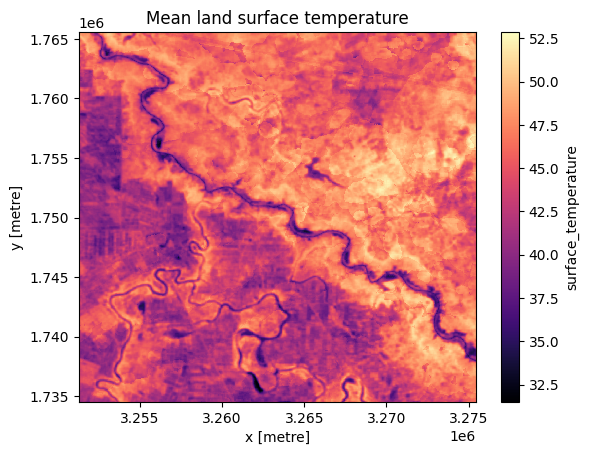

In [7]:
# plot
ds_land.surface_temperature.plot.imshow(cmap="magma")
plt.title("Mean land surface temperature");

## Load ERA5 Air Temperature data

While Landsat 8 will observe a given location once every few days, ERA5 provides hourly observations. As such, the next step calculates the monthly average air temperature from ERA5, using the `resample` and `reduce_func` arguments. The load_era5 function returns the temperature in Kelvin, so it must be converted to Celcius using the offset.

After calculating this, the last step is to take the average of the monthly means to get a seasonal mean air temperature, which will be used for the analysis.

In [8]:
# load ERA5 air temperature at 2m height, resampled to monthly means
var = "air_temperature_at_2_metres"
ds_air = (
    load_era5(var, lat_range, lon_range, time, resample="1MS", reduce_func=np.mean)[var]
    - celcius_kelvin_offset
)
ds_air = ds_air.compute()  # bring into memory

# rename dimensions to match landsat
ds_air = ds_air.rename({"lon": "x", "lat": "y"})

# Seasonal mean air temp
ds_air = ds_air.mean("time")

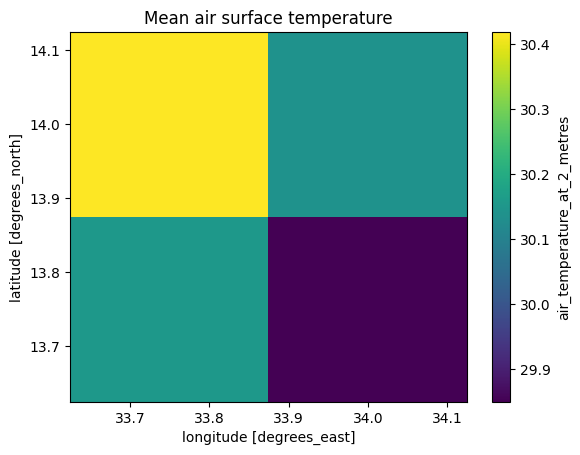

In [9]:
# plot
ds_air.plot.imshow(cmap="viridis")
plt.title("Mean air surface temperature");

The above plots show the data has loaded correctly. Note that ERA5 has a much lower spatial resolution than Landsat 8 (approximately 31km compared to 30m) but has a much higher temporal resolution. 

It is also expected that land temperature will be higher than 2 metre air temperature. 

Note the land temperature estimated by Landsat 8 can seem quite high; here, it is shown in excess of 40 degrees Celsius. In this notebook, we do not have the means to validate the dataset so it is difficult to tell if the readings are accurate, or exaggerated due to inherent instrumentation error. Regardless, this is mitigated by $\Delta T$ which looks at the difference between temperatures instead of absolute values.

## Calculate $\Delta T$

As noted in the introduction, for this exercise we estimate $\Delta T$ using the loaded temperature datasets in lieu of in-situ data. This can be broken down into the following steps:

1. Resample the air temperature to match the spatial resolution of Landsat. This is done using the `xr_reproject` function.
2. Calculate the difference ($\Delta T$) between $T_c$ (land temperature) and $T_a$ (air temperature)


In [10]:
ds_air = xr_reproject(src=ds_air, geobox=ds_land.geobox, resampling="nearest")

Calculate $\Delta T$:

In [11]:
deltat = ds_land.surface_temperature - ds_air

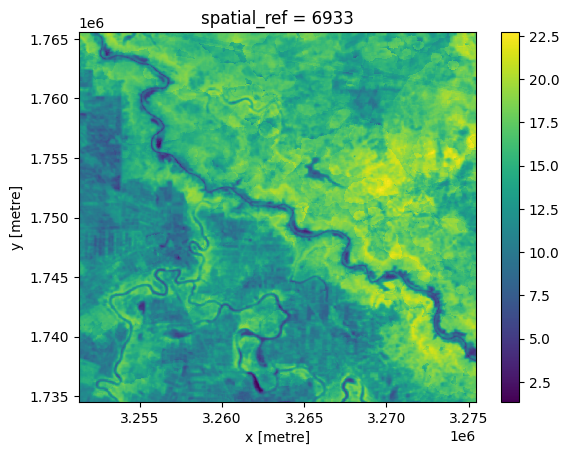

In [12]:
deltat.plot.imshow();

## Load Landsat-8 Surface Reflectance data and calculate NDVI

In [13]:
ds_ndvi = load_ard(
    dc=dc,
    products=["ls8_sr"],
    like=ds_land.geobox,
    time=time,
    skip_broken_datasets=True,
    measurements=["red", "nir"],
)

ds_ndvi = calculate_indices(ds_ndvi, index="NDVI", satellite_mission="ls", drop=True)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 24 time steps
Dropping bands ['red', 'nir']


In [14]:
ds_ndvi = ds_ndvi.median("time").squeeze()

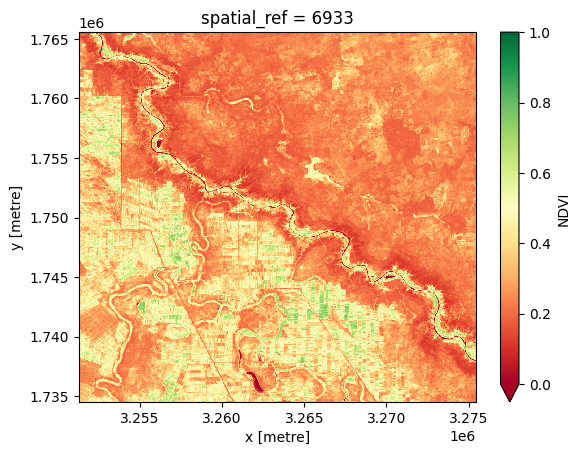

In [15]:
ds_ndvi.NDVI.plot.imshow(cmap="RdYlGn", vmin=0, vmax=1);

## Use the Cropland extent product for masking cropping regions

We can use $\Delta T$ to differentiate between irrigated and dryland cropping, but to do this we need to restrict our analysis to cropland and exclude other landscape features. We can do this using the cropland extent product, which we load below.

### Load crop mask

In [16]:
cm = dc.load(
    product="crop_mask", time="2019", measurements="filtered", like=ds_ndvi.geobox
).filtered.squeeze()

In [17]:
deltat = deltat.where(cm==1)
ds_ndvi = ds_ndvi.where(cm==1)

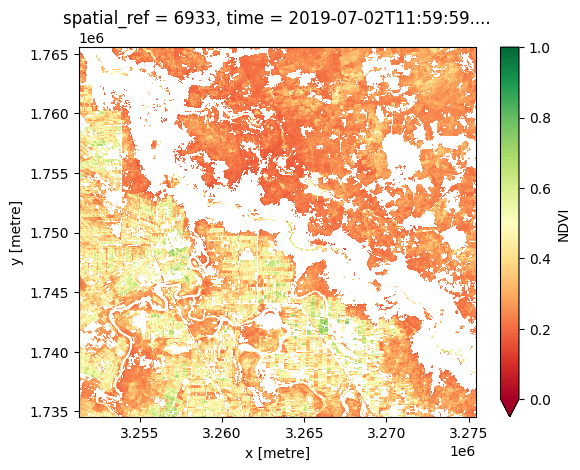

In [18]:
ds_ndvi.NDVI.plot.imshow(cmap="RdYlGn", vmin=0, vmax=1);

## Identify clusters for classification

We have two variables (NDVI and $\Delta T$) that we'd like to use to split dryland and irrigated cropland.

We can use a cluster technique to assign the data to these classes. In this case, we'll use k-means clustering to identify two clusters (irrigated and rainfed). 

As the two variables have quite different units, we'll need to rescale them before running the cluster analysis. This is shown in the cell below.

In [19]:
# flatten the two predictors into 1-D arrays
ndvi_flat = sklearn_flatten(ds_ndvi.NDVI)
deltat_flat = sklearn_flatten(deltat)

# combine the two arrays for passing into kmeans
X = np.stack((ndvi_flat, deltat_flat), axis=0).transpose()

# rescale variables for cluster analysis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# perform kmeans cluster analysis, specifying we are looking for two clusters
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_scaled)
y_kmeans = kmeans.predict(X_scaled)

# create a lookup table for the clusters so results are reproducible
idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(2)
kmeans.labels_ = lut[kmeans.labels_]

## Plot the clusters

The plot below shows the 2D histogram of the NDVI-$\Delta T$ pairs (conveying the density of points), as well as a scatter plot showing which cluster each pair was assigned to. Both plots display the centre of each cluster. 

The density shows two distinct clusters that the k-means algorithm has identified in the data. We assume to cluster to the bottom-right (higher NDVI and lower $\Delta T$) is the irrigated cropland.

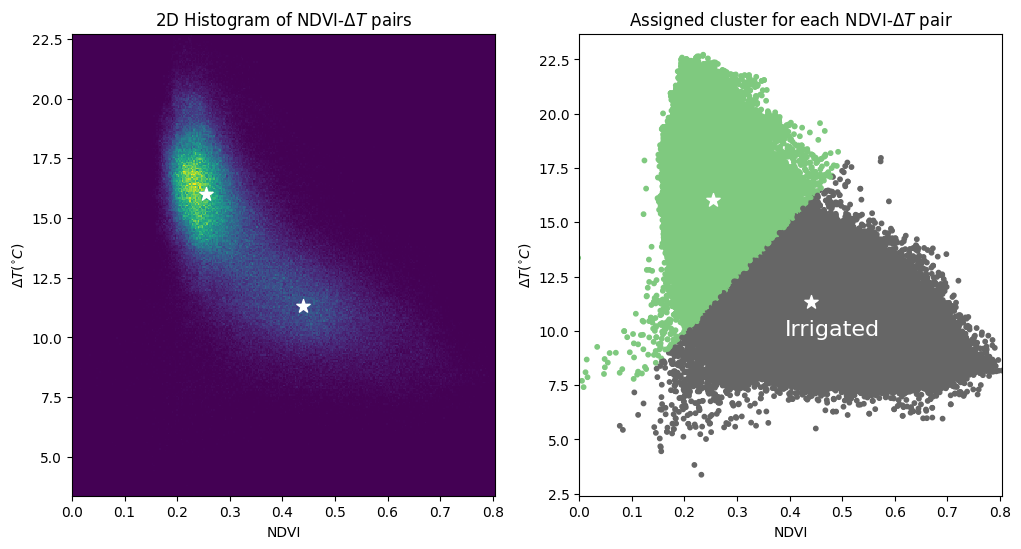

In [20]:
# Get locations of kmeans cluster centres
centers_scaled = kmeans.cluster_centers_
centers = scaler.inverse_transform(centers_scaled)

# Construct the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist2d(X[:, 0], X[:, 1], bins=(300, 300), cmap="viridis")
ax1.scatter(centers[:, 0], centers[:, 1], c="white", s=100, marker="*")
ax1.set_xlim(0, ds_ndvi.NDVI.max())
ax1.set_xlabel("NDVI")
ax1.set_ylabel("$\Delta T (^{\circ} C)$")
ax1.set_title("2D Histogram of NDVI-$\Delta T$ pairs")

ax2.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=10, cmap="Accent")
ax2.scatter(centers[:, 0], centers[:, 1], c="white", s=100, marker="*")
ax2.set_xlim(0, ds_ndvi.NDVI.max())
ax2.set_xlabel("NDVI")
ax2.set_ylabel("$\Delta T (^{\circ} C)$")
ax2.text(
    centers[1, 0] - 0.05, centers[1, 1] - 1.5, "Irrigated", fontsize=16, color="white"
)
ax2.set_title("Assigned cluster for each NDVI-$\Delta T$ pair")

plt.show()

## Apply clusters to the spatial data

In [21]:
# use kmeans to predict which cluster each observation belongs to
preds_flat = kmeans.predict(X_scaled)

# unflatten predictions to return it to spatial dimensions
preds = sklearn_unflatten(preds_flat, ds_ndvi)

# irrigated (c) where cropland is true and cluster = 0
c = xr.where((cm == 1) & (preds == 1), 2, cm)

Load semi-annual geomedian to compare classification to a true-colour image.

In [22]:
gm = dc.load(
    product="gm_s2_semiannual",
    like=cm.geobox,
    time=time,
    measurements=["red", "green", "blue"],
).squeeze()

### Plot result

The following produces a three-panel plot, showing the geomedian for reference, then the total cropland extent, and finally, areas classified as active irrigation in yellow.

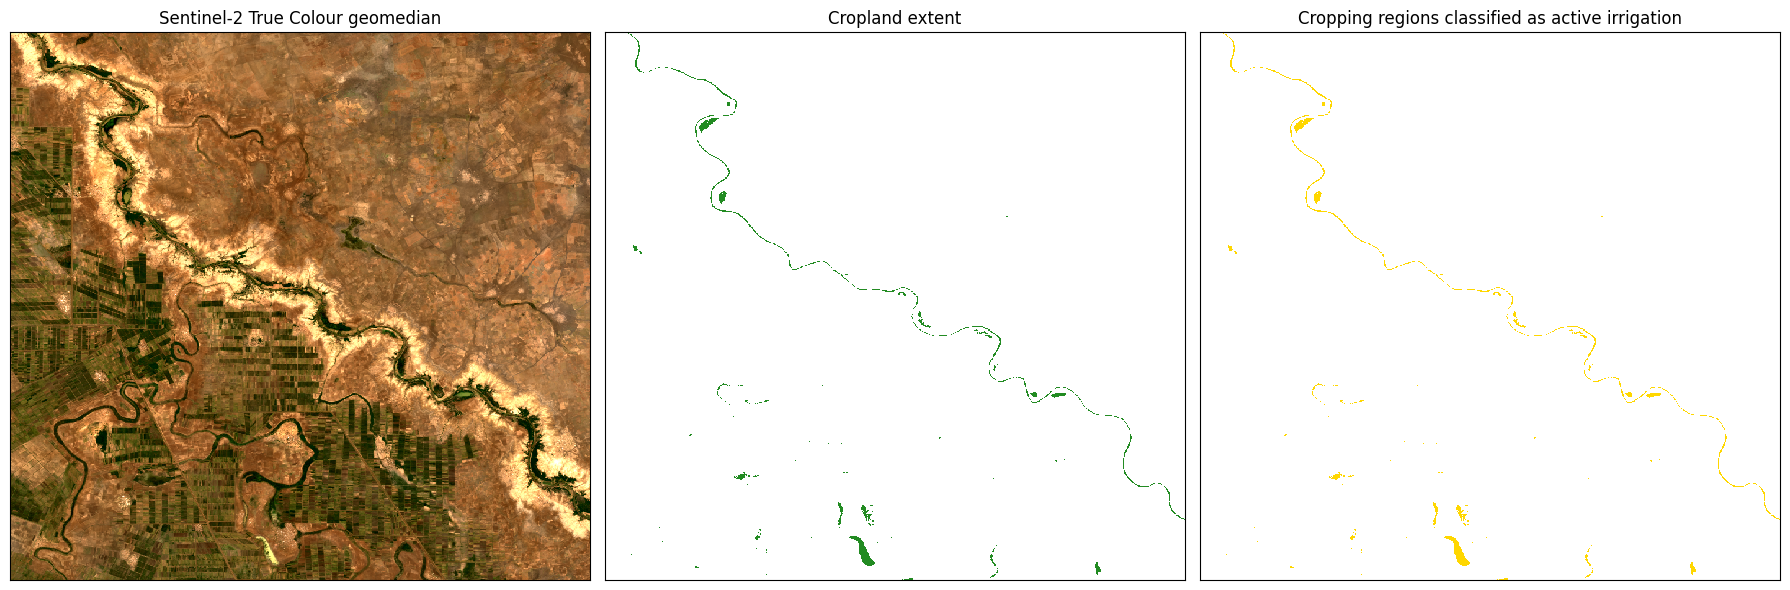

In [23]:
colours = ["white", "forestgreen", "gold"]

fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Geomedian
rgb(gm, index=1, ax=ax[0])
ax[0].set_title("Sentinel-2 True Colour geomedian")

# Cropland extent
cm.plot(ax=ax[1], add_colorbar=False, cmap=ListedColormap(colours[0:2]))
ax[1].set_title("Cropland extent")

# Irrigated cropping
c.plot(ax=ax[2], add_colorbar=False, cmap=ListedColormap(colours))
ax[2].set_title("Cropping regions classified as active irrigation")

# Turn axis ticks and labels off on all axes
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel("")
    axis.set_ylabel("")


plt.tight_layout();

## Limitations

This method of calculating $\Delta T$ is based on several key assumptions:

* Air temperature is reasonably approximated by ERA5
* Land temperature is reasonably approximated by Landsat 8 Surface Temperature

The cluster based differentiation of irrigated and dryland cropping is reliant on these two features being related these variables. This approach may be less effective in some scenarios, such as:

* Wet seasons where dryland crops are experiencing low levels of moisture stress and high canopy greenness.
* Cold times when $\Delta T$ may not be a good indicator of crop moisture stress.

As always, results should be interpreted with context and care.

## References

Jackson, Ray D., Kustas, William P., and Choudhury, Bhaskar J. 1988. 'A Reexamination of the Crop Water Stress Index'. *Irrig Sci* 9:309-317

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [24]:
print(datacube.__version__)

1.8.12


**Last Tested:**

In [25]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-04-16'